In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

answer = {True:'Yes', False:'No'}
warnings.filterwarnings('ignore')

# Reading and Wrangling Data

In [2]:
def calculate_age(x):
    try:
        bdate = pd.to_datetime(x, format='%d.%m.%Y')
        today = pd.to_datetime('today')
        return (today - bdate) // np.timedelta64(1, 'Y')
    except:
        return np.nan

In [3]:
# Reading json file
json_file = json.load(open('params.json'))
me = int(json_file['source_id'])

In [4]:
# Reading data
df_friends = pd.read_csv('vk.csv')

# Cleaning data
## Dropping "DELETED" accounts
df_friends = df_friends.loc[df_friends.first_name!='DELETED']
## Dropping duplicates
df_friends.drop_duplicates(subset=['source_id','first_name','last_name','sex','bdate','country','city','mobile_phone'],
                           inplace=True)
## Calculating age
df_friends['age'] = df_friends.bdate.apply(calculate_age)
df_friends['age_cut'] = pd.cut(df_friends.age, bins=[0, 18, 25, 30, 40, 50, 60, 70, df_friends.age.max()])

df_friends.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22572 entries, 0 to 25355
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   source_id     22572 non-null  int64   
 1   id            22572 non-null  int64   
 2   first_name    22572 non-null  object  
 3   last_name     22572 non-null  object  
 4   sex           22562 non-null  object  
 5   bdate         14820 non-null  object  
 6   country       17058 non-null  object  
 7   city          15026 non-null  object  
 8   mobile_phone  2035 non-null   object  
 9   age           6925 non-null   float64 
 10  age_cut       6925 non-null   category
dtypes: category(1), float64(1), int64(2), object(7)
memory usage: 1.9+ MB


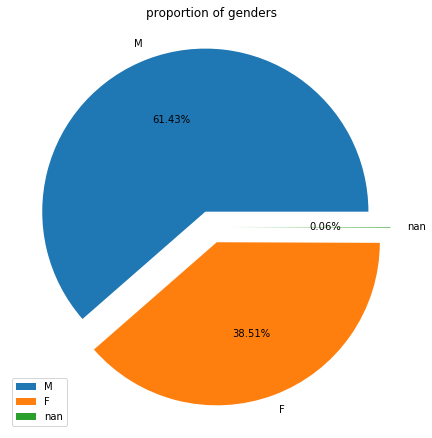

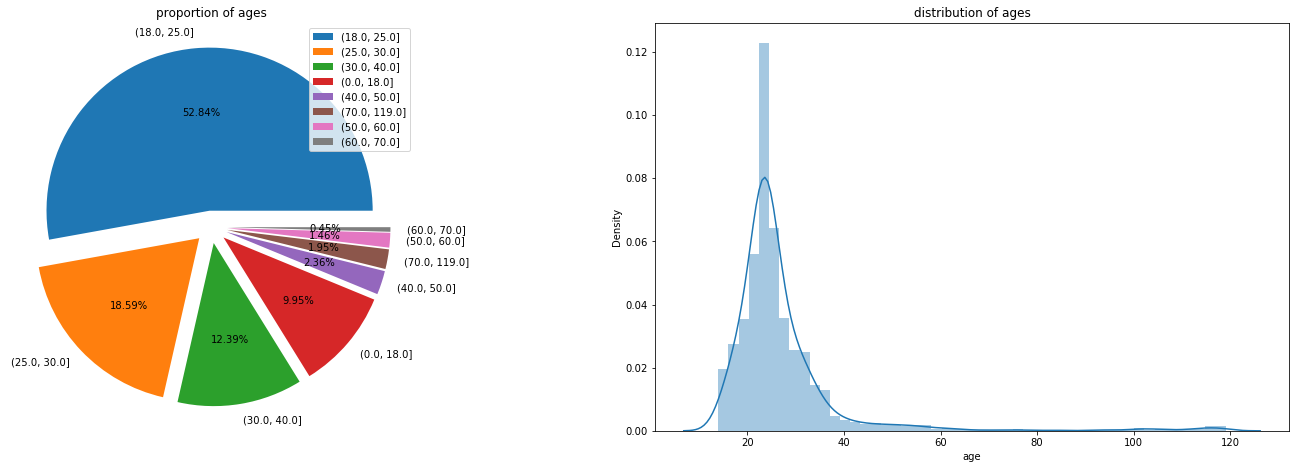

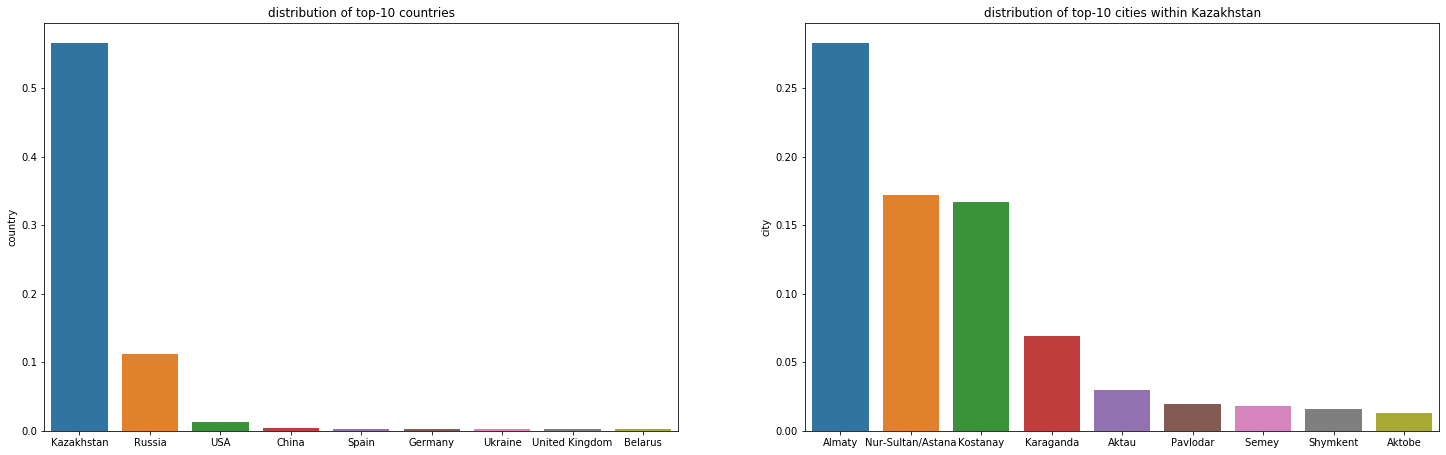

In [5]:
# Creating DataFrame for analysis without duplicates
df_analysis = df_friends.copy()
df_analysis.drop(columns=['source_id'], inplace=True)
df_analysis.drop_duplicates(inplace=True)

# Creating DataFrames for plotting graphs
## Gender
df_genders = df_analysis.sex.value_counts(dropna=False, normalize=True)
## Age
df_age_cuts = df_analysis.age_cut.value_counts(dropna=True, normalize=True)
## Countries
df_countries = df_analysis.country.value_counts(dropna=False, normalize=True).to_frame()
df_countries.sort_values(by='country', ascending=False, inplace=True)
df_countries = df_countries[:10]
## Cities within Kazakhstan
df_kz_cities = df_analysis.loc[df_analysis.country=='Kazakhstan'].city.value_counts(dropna=False, normalize=True).to_frame()
df_kz_cities.sort_values(by='city', ascending=False, inplace=True)
df_kz_cities = df_kz_cities[:10]

# Graph of "proportion of genders"
f, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.pie(df_genders, labels=df_genders.index, autopct='%1.2f%%', explode=[0.1 for i in range(len(df_genders))])
ax.legend(); ax.set_title('proportion of genders')
plt.show()

# Graphs of "proportion of ages" & "distribution of ages"
f, ax = plt.subplots(1, 2, figsize=(25, 7.5))
## "proportion of ages"
ax[0].pie(df_age_cuts, labels=df_age_cuts.index, autopct='%1.2f%%', explode=[0.1 for i in range(len(df_age_cuts))])
ax[0].legend(); ax[0].set_title('proportion of ages')
## "distribution of ages"
sns.distplot(df_analysis.age, ax=ax[1])
ax[1].set_title('distribution of ages')
plt.show()

# Graphs of "distribution of top-10 countries" & "distribution of top-10 cities within Kazakhstan"
f, ax = plt.subplots(1, 2, figsize=(25, 7.5))
## "distribution of top-10 countries"
sns.barplot(x=df_countries.index, y='country', data=df_countries, ax=ax[0])
ax[0].set_title('distribution of top-10 countries')
## "distribution of top-10 cities within Kazakhstan"
sns.barplot(x=df_kz_cities.index, y='city', data=df_kz_cities, ax=ax[1])
ax[1].set_title('distribution of top-10 cities within Kazakhstan')
plt.show()

# Social Graph

### Graph that includes me

In [6]:
# Creating a Social Graph (including me)
G1 = nx.Graph(name='including me')

# Nodes
df_nodes = df_analysis[['id','first_name','last_name','sex']].copy()
df_nodes.set_index('id', inplace=True)
dict_nodes = df_nodes.to_dict(orient='index')
list_nodes = [(key, dict_nodes[key]) for key in dict_nodes]
# Adding nodes into the graph
G1.add_nodes_from(list_nodes)

# Edges
edges = df_friends[['source_id','id']].to_records(index=False)
## Adding edges into the graph
G1.add_edges_from(edges)

# Basic info
print(nx.info(G1))

Name: including me
Type: Graph
Number of nodes: 14809
Number of edges: 21767
Average degree:   2.9397


In [7]:
# Connectivity
print(f'1. Is G1 connected? {answer[nx.is_connected(G1)]}.')
print(f'2. Average clustering: {nx.average_clustering(G1)}.')
print(f'3. Transitivity: {nx.transitivity(G1)}.')

1. Is G1 connected? Yes.
2. Average clustering: 0.10127152553964401.
3. Transitivity: 0.01902028645578026.


In [8]:
%%time
# Distance measures
print(f'1. Average shortest path length (G1): {nx.average_shortest_path_length(G1)}.')
print(f'2. Diameter (G1): {nx.diameter(G1)}.')
print(f'3. Radius (G1): {nx.radius(G1)}.')

1. Average shortest path length (G1): 3.774316810352926.
2. Diameter (G1): 4.
3. Radius (G1): 2.
CPU times: user 7min 8s, sys: 35.4 ms, total: 7min 8s
Wall time: 7min 8s


CPU times: user 7min 49s, sys: 33.8 s, total: 8min 23s
Wall time: 7min 42s


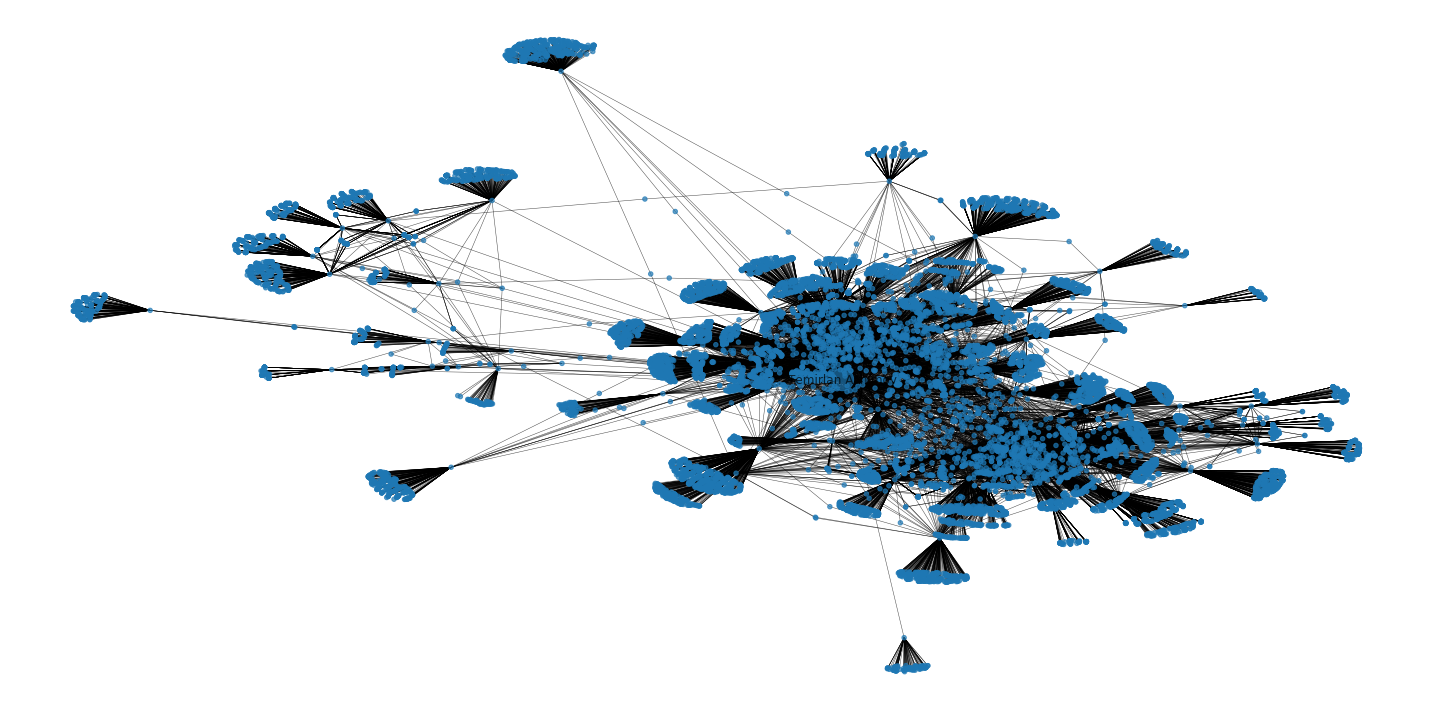

In [14]:
%%time
# Drawing the graph
## Labeling my node
labels = {me:'Temirlan Ashimov'}
node_size = [500 if node==me else 20 for node in G1.nodes()]
## Drawing the graph
plt.figure(figsize=(20,10))
nx.draw_networkx(G1, node_size=node_size, alpha=0.7, labels=labels, width=0.5)
plt.axis('off')
plt.tight_layout();

### Graph that excludes me

In [10]:
# Creating a Social Graph (excluding me)
G2 = nx.Graph(name='excluding me')

# Nodes
df_nodes = df_analysis[['id','first_name','last_name','sex']].copy()
df_nodes.set_index('id', inplace=True)
dict_nodes = df_nodes.to_dict(orient='index')
list_nodes = [(key, dict_nodes[key]) for key in dict_nodes]
# Adding nodes into the graph
G2.add_nodes_from(list_nodes)

# Edges
edges = df_friends[['source_id','id']].to_records(index=False)
## Adding edges into the graph
G2.add_edges_from(edges)

# Removing my node from the graph
G2.remove_node(me)

# Taking the "biggest" connected component as subgraph
G2 = nx.Graph.subgraph(G2, nodes=sorted(nx.connected_components(G2), key=len, reverse=True)[0])

# Basic info
print(nx.info(G2))

Name: excluding me
Type: Graph
Number of nodes: 14718
Number of edges: 21524
Average degree:   2.9249


In [11]:
# Connectivity
print(f'1. Is subgraph of G2 connected? {answer[nx.is_connected(G2)]}.')
print(f'2. Average clustering: {nx.average_clustering(G2)}.')
print(f'3. Transitivity: {nx.transitivity(G2)}.')

1. Is subgraph of G2 connected? Yes.
2. Average clustering: 0.10160086073743327.
3. Transitivity: 0.018023317134118144.


In [12]:
%%time
# Distance measures
print(f'1. Average shortest path length (G2): {nx.average_shortest_path_length(G2)}.')
print(f'2. Diameter (G2): {nx.diameter(G2)}.')
print(f'3. Radius (G2): {nx.radius(G2)}.')

1. Average shortest path length (G2): 4.693067669052551.
2. Diameter (G2): 11.
3. Radius (G2): 6.
CPU times: user 56min 7s, sys: 4.6 s, total: 56min 12s
Wall time: 56min 15s


CPU times: user 7min 53s, sys: 33.4 s, total: 8min 26s
Wall time: 7min 45s


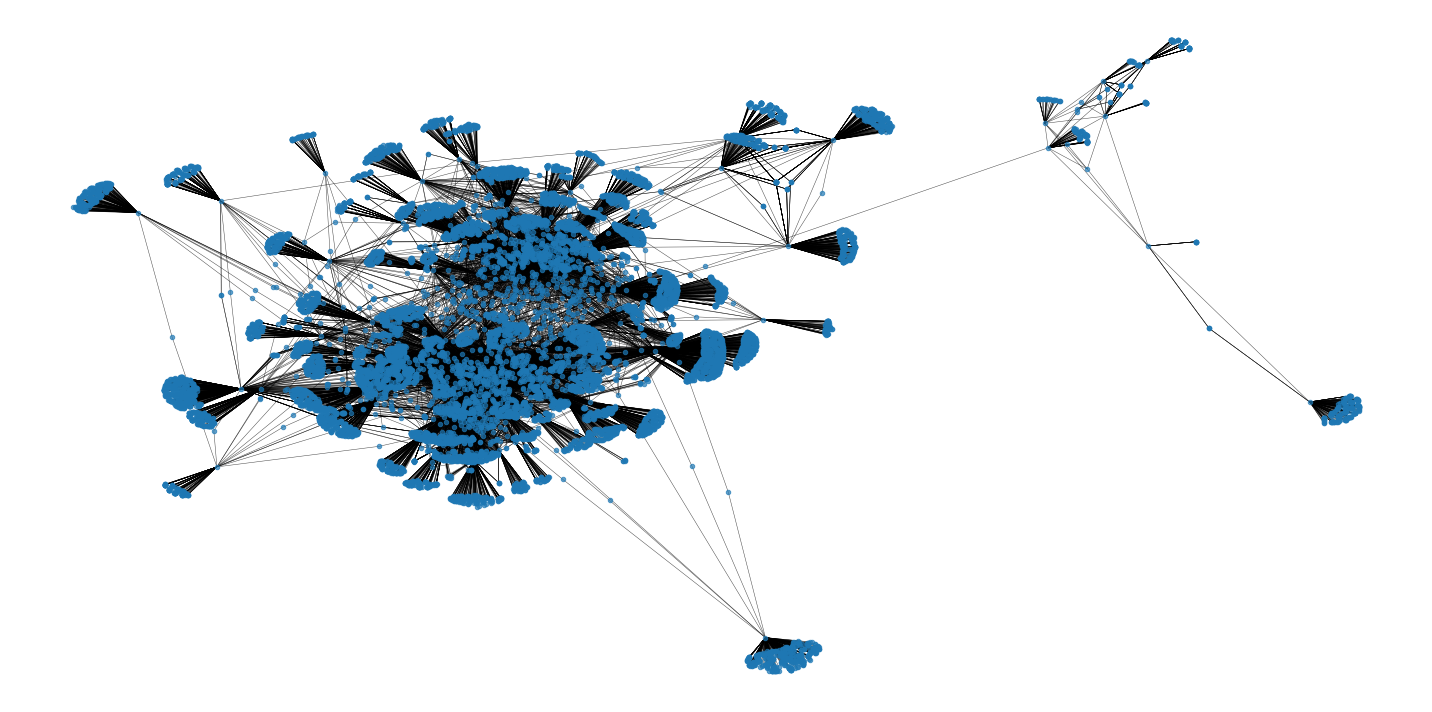

In [13]:
%%time
## Drawing the graph
plt.figure(figsize=(20,10))
nx.draw_networkx(G2, node_size=20, alpha=0.7, with_labels=False, width=0.5)
plt.axis('off')
plt.tight_layout();